In [ ]:
from fastai.vision.all import *
path = Path('/content/drive/MyDrive/data1')

In [ ]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,0,water_pollution,NaN
1,1,water_pollution,NaN
2,2,water_pollution,NaN
3,3,water_pollution,NaN
4,4,water_pollution,NaN


In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(),
                   get_x=ColReader(0, pref=f'{path}/train/', suff='.jpg'),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

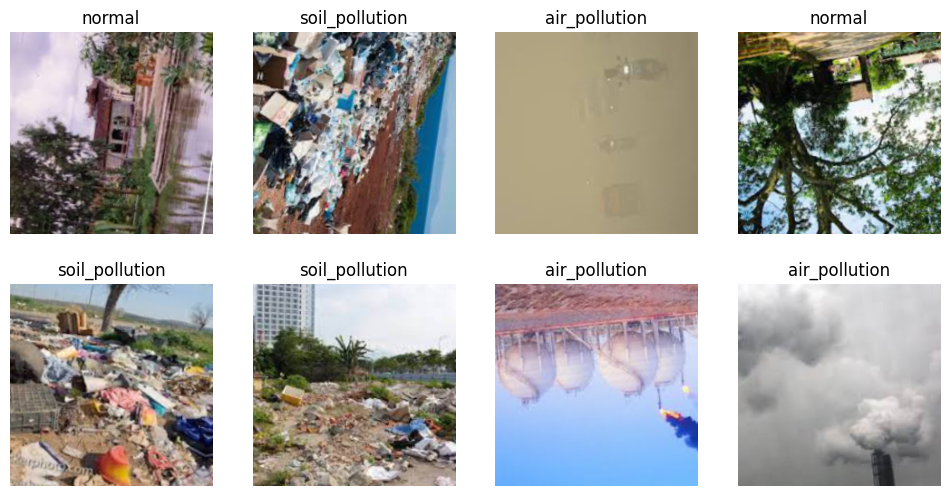

In [ ]:
dls = dblock.dataloaders(df)
dls.show_batch(nrows=2, ncols=4)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0012022644514217973)

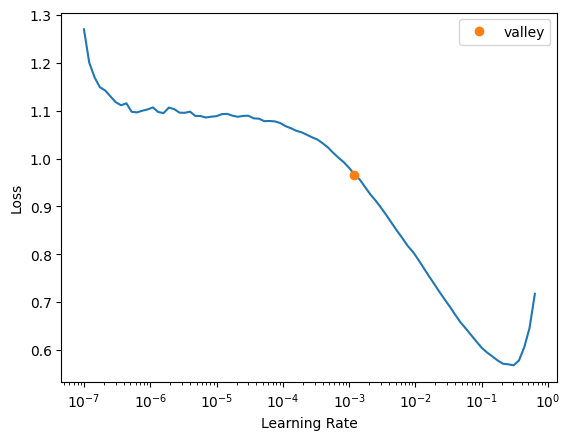

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.047005,1.106674,0.531250,00:07
1,1.016876,0.970816,0.552083,00:01
2,1.009518,0.879614,0.593750,00:01
3,0.970989,0.807599,0.635417,00:01
4,0.937195,0.752683,0.666667,00:01


In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(valley=0.00015848931798245758)

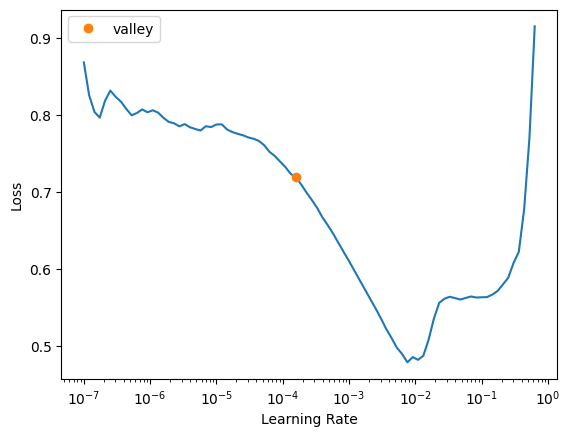

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.274045,0.396801,0.791667,00:01
1,0.293630,0.390465,0.791667,00:01
2,0.280541,0.386358,0.791667,00:01
3,0.268733,0.392545,0.812500,00:01
4,0.258354,0.395738,0.802083,00:01
5,0.261855,0.405517,0.802083,00:01
6,0.265696,0.412271,0.802083,00:01
7,0.258891,0.411221,0.802083,00:01
8,0.253206,0.412829,0.791667,00:01
9,0.252180,0.413767,0.802083,00:01


In [ ]:
from sklearn.metrics import f1_score

preds, targs = learn.get_preds()
f1 = f1_score(targs, preds>0.5, average='macro')
print(f1)

0.6378317334839074


In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

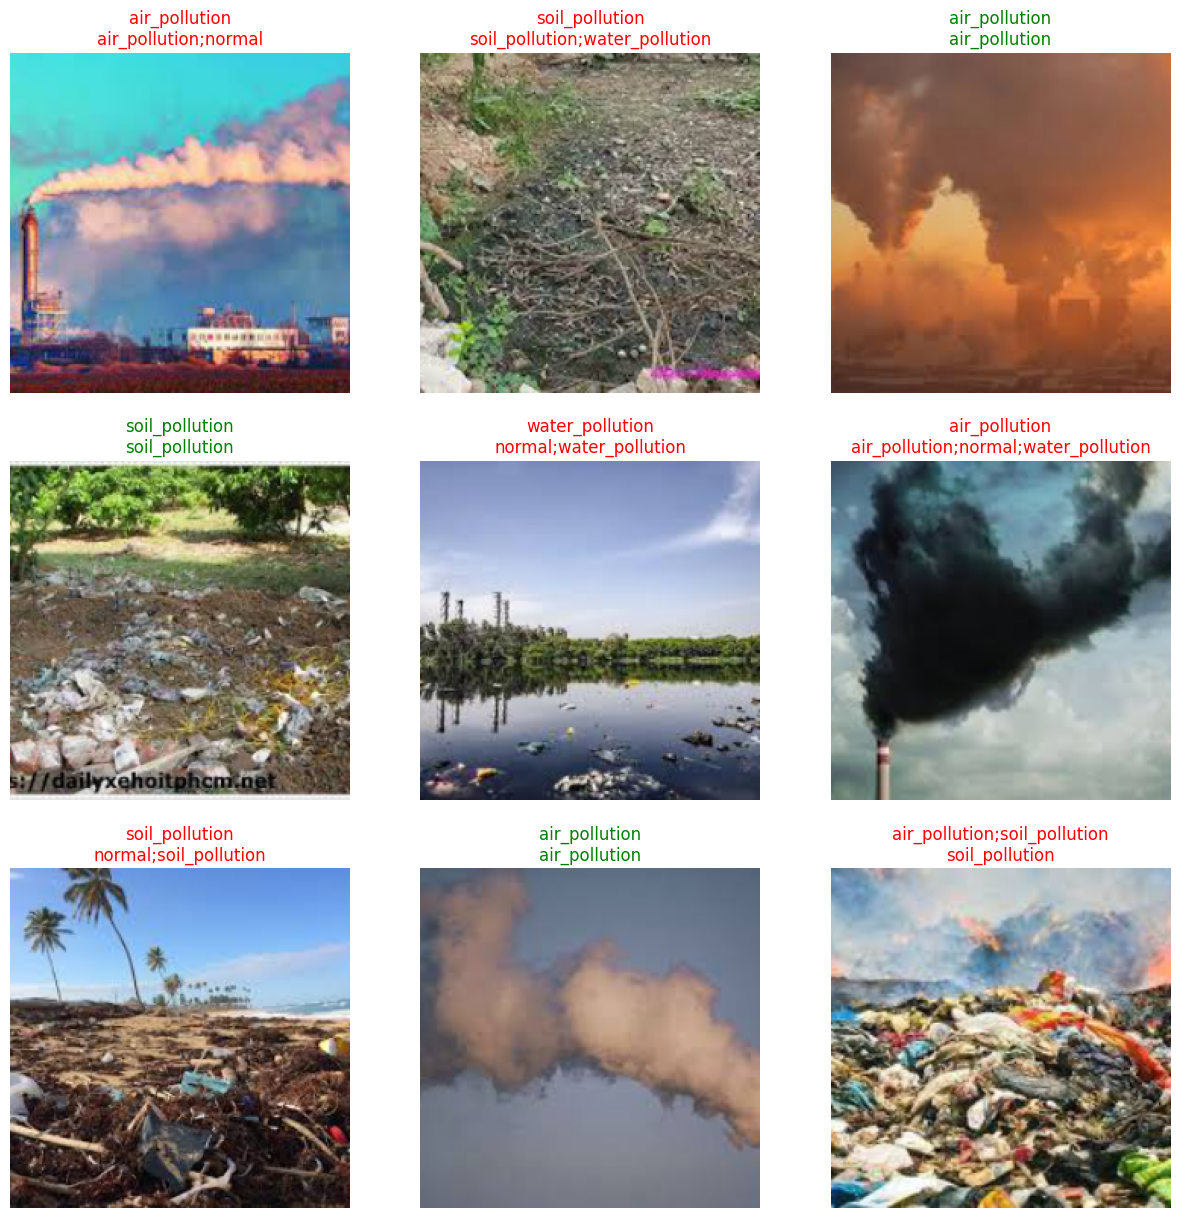

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
from IPython.display import Image, display
#Image('/content/drive/MyDrive/test/kp1.jpg')

In [ ]:
dls.vocab

['air_pollution', 'normal', 'soil_pollution', 'water_pollution']

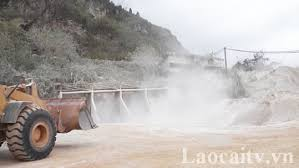

((#2) ['air_pollution','normal'],
 tensor([ True,  True, False, False]),
 tensor([0.9541, 0.6429, 0.0039, 0.3754]))

In [ ]:
img = '/content/drive/MyDrive/test/kp1.jpg'
display(Image(img))
learn.predict(img)

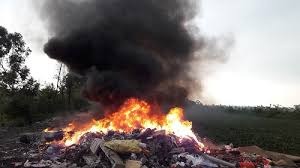

In [ ]:
img = '/content/drive/MyDrive/test/images (10).jpg'
display(Image(img))
#learn.predict(img)
pred_class, pred_idx, outputs = learn.predict(img)

In [ ]:
result = {'air_pollution':float(outputs[0]), 'nomal':float(outputs[1]),'soil_pollution':float(outputs[2]), 'water_pollution':float(outputs[3])}
result

{'air_pollution': 0.9608049392700195,
 'nomal': 0.37284767627716064,
 'soil_pollution': 0.11576064676046371,
 'water_pollution': 0.16211456060409546}

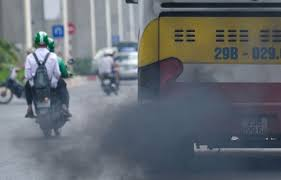

((#2) ['air_pollution','normal'],
 tensor([ True,  True, False, False]),
 tensor([8.8364e-01, 9.6802e-01, 4.2721e-04, 3.4290e-01]))

In [ ]:
img = '/content/drive/MyDrive/test/images (9).jpg'
display(Image(img))
learn.predict(img)

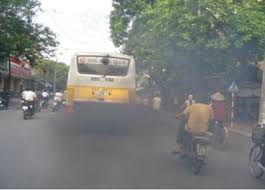

((#2) ['air_pollution','normal'],
 tensor([ True,  True, False, False]),
 tensor([0.8907, 0.9970, 0.0011, 0.0821]))

In [ ]:
img = '/content/drive/MyDrive/test/images (8).jpg'
display(Image(img))
learn.predict(img)

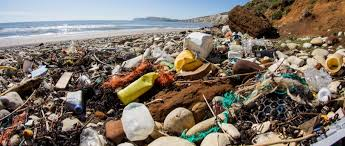

((#1) ['soil_pollution'],
 tensor([False, False,  True, False]),
 tensor([0.4710, 0.3397, 0.7907, 0.4555]))

In [ ]:
img = '/content/drive/MyDrive/test/images (7).jpg'
display(Image(img))
learn.predict(img)

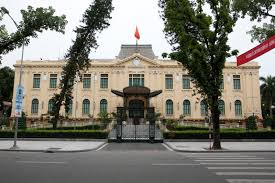

((#1) ['normal'],
 tensor([False,  True, False, False]),
 tensor([0.3137, 0.6352, 0.0295, 0.0778]))

In [ ]:
img = '/content/drive/MyDrive/test/images (1).jpg'
display(Image(img))
learn.predict(img)